In [49]:
from os import listdir
from os.path import isfile, join
import re
demographic_files = [f for f in listdir('BabyNames/') if isfile(join('BabyNames/', f)) and re.search('^yob\d', f)]
demographic_files.sort()

In [50]:
import pandas as pd
def read_file(file_name):
    year = re.search('yob(\d+).txt', file_name).group(1)
    df = pd.read_csv('BabyNames/{0}'.format(file_name), sep=',', header=None)
    df.columns = ['Name', 'Sex', 'Count']
    df['Year'] = year
    return df

read_data_frames = [read_file(f_name) for f_name in demographic_files]

# Выполнение пункта 1 задания "Сгруппируйте данные по полу и году и визуализируйте общую динамику рождаемости обоих полов"

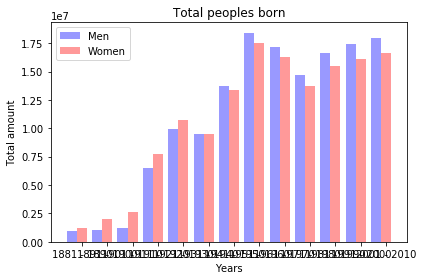

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

start_index = 1
end_index = 130
interval = 10

n_groups = len(read_data_frames[start_index:end_index]) / interval

years = []
mens_amount = []
womens_amount = []

def year_interval_name(frames, start_index, end_index):
    start_year = frames[start_index].loc[0]['Year']
    end_year = frames[end_index].loc[0]['Year']
    return '{0} - {1}'.format(start_year, end_year)

for index in range(start_index, end_index, interval):
    start_frame_index = index
    end_frame_index = index + interval - 1
    interval_mens_amount = 0
    interval_womens_amount = 0
    for frame in read_data_frames[start_frame_index:end_frame_index]:
        interval_mens_amount += frame.loc[frame['Sex'] == 'M', ['Count']].sum()['Count']
        interval_womens_amount += frame.loc[frame['Sex'] == 'F', ['Count']].sum()['Count']

    years += [year_interval_name(read_data_frames, start_frame_index, end_frame_index)]
    mens_amount += [interval_mens_amount]
    womens_amount += [interval_womens_amount]

years_values = tuple(years)
womens_values = tuple(womens_amount)
mens_values = tuple(mens_amount)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, mens_values, bar_width,
                alpha=opacity, color='b',
                label='Men')

rects2 = ax.bar(index + bar_width, womens_values, bar_width,
                alpha=opacity, color='r',
                label='Women')

ax.set_xlabel('Years')
ax.set_ylabel('Total amount')
ax.set_title('Total peoples born')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(years_values)
ax.legend()

fig.tight_layout()
plt.rcParams["figure.figsize"] = [30, 4.8]
plt.show()



# Выполнение пункта 2 задания "Найдите самые популярные имена за всю историю"

Количество людей по годам сильно меняется. Следовательно нельзя просто сложить количества людей и получить ответ.
Кроме этого очевидно что надо брать те, что на вершине списка т.к. в дата фрейме данные уже отсортированы по частоте.
Предположительно необхоимо найти N (у нас N будет 500) наиболее часто встречающихся, в процентном соотношении для совего года. Посчитать статистику по всем годам. И вот тут уже сложить все проценты и отсортировать по суммарному значению.

In [51]:
def count_percentage_for_set(data_frame, gender, limit=500):
    filtered_by_gender = data_frame.loc[data_frame['Sex'] == gender]
    probe = filtered_by_gender[0:limit]
    total_count = filtered_by_gender.get(['Count']).sum()['Count']
    probe['Relative frequency'] = probe['Count'].map(lambda count: count / total_count)
    result = probe.get(['Name', 'Relative frequency'])
    return result

def get_most_frequent(percentages_list, limit=150):
    total_data_frame = pd.concat(percentages_list).groupby(['Name']).sum()
    result = total_data_frame.sort_values(by='Relative frequency', ascending=False)[0:limit]
    return result

male_percentages = []
for frame in read_data_frames:
    male_percentages += [count_percentage_for_set(frame, 'M')]

female_percentages = []
for frame in read_data_frames:
    female_percentages += [count_percentage_for_set(frame, 'F')]

chart_size = 10
males_chart = get_most_frequent(male_percentages, chart_size)
females_chart = get_most_frequent(female_percentages, chart_size)



/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


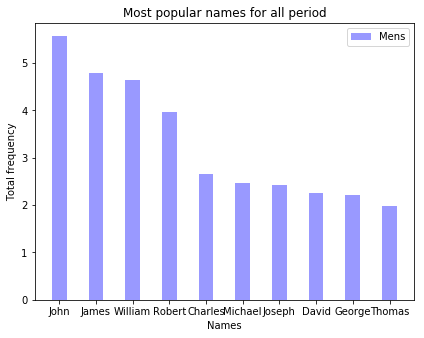

In [54]:

male_fig, male_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

male_values = tuple([values[0] for values in males_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
male_names = tuple(males_chart[0:chart_size].index.get_values())

most_popular_male_names = male_ax.bar(index, male_values, bar_width,
                                      alpha=opacity, color='b',
                                      label='Mens')

male_ax.set_xlabel('Names')
male_ax.set_ylabel('Total frequency')
male_ax.set_title('Most popular names for all period')
male_ax.set_xticks(index)
male_ax.set_xticklabels(male_names)
male_ax.legend()

male_fig.tight_layout()
plt.rcParams["figure.figsize"] = [6, 4.8]
plt.show()

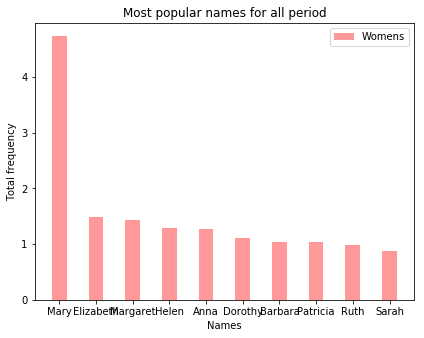

In [55]:
female_fig, female_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

female_values = tuple([values[0] for values in females_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
female_names = tuple(females_chart[0:chart_size].index.get_values())

most_popular_female_names = female_ax.bar(index, female_values, bar_width,
                                      alpha=opacity, color='r',
                                      label='Womens')

female_ax.set_xlabel('Names')
female_ax.set_ylabel('Total frequency')
female_ax.set_title('Most popular names for all period')
female_ax.set_xticks(index)
female_ax.set_xticklabels(female_names)
female_ax.legend()

female_fig.tight_layout()
plt.rcParams["figure.figsize"] = [6, 4.8]
plt.show()